In [1]:
# !pip install fastai==0.7.0

In [3]:
# import tarfile
# tar = tarfile.open("models_Procedures_top10_noteevents_633K_80-20split_lm_3epochs_classifier_17epochs.tar.gz")
# tar.extractall()
# tar.close()

In [2]:
%pwd

'/home/snuthakk/Capstone/mimic_proce_seq1_top10_80:20split'

In [5]:
import sys, os
os.listdir()
sys.path.append('/usr/local/anaconda3/lib/python3.6/site-packages')
sys.path.append('/home/snuthakk/.local/bin')
import numpy as np
import pandas as pd

In [6]:
from fastai.text import *
import html

In [7]:
import sys, os
print(sys.path)

['', '/home/snuthakk/.conda/envs/py36/lib/python36.zip', '/home/snuthakk/.conda/envs/py36/lib/python3.6', '/home/snuthakk/.conda/envs/py36/lib/python3.6/lib-dynload', '/home/snuthakk/.local/lib/python3.6/site-packages', '/home/snuthakk/.local/lib/python3.6/site-packages/mritopng-2.2-py3.6.egg', '/home/snuthakk/.conda/envs/py36/lib/python3.6/site-packages', '/home/snuthakk/.conda/envs/py36/lib/python3.6/site-packages/IPython/extensions', '/home/snuthakk/.ipython', '/usr/local/anaconda3/lib/python3.6/site-packages', '/home/snuthakk/.local/bin']


In [8]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('/home/snuthakk/Capstone/mimic_proce_seq1_top10_80:20split/')

In [9]:
CLAS_PATH=Path('/home/snuthakk/Capstone/mimic_proce_seq1_top10_80:20split/mimic_proce_seq1_top10_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('/home/snuthakk/Capstone/mimic_proce_seq1_top10_80:20split/mimic_proce_seq1_top10_lm/')
LM_PATH.mkdir(exist_ok=True)

In [5]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')

In [6]:
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

In [7]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [8]:
vs=len(itos)
vs,len(trn_lm)

(60002, 506395)

# wikitext103 conversion

In [9]:
em_sz,nh,nl = 400,1150,3

In [10]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [11]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [12]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [13]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [14]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [15]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language model

In [16]:
wd=1e-7
bptt=30
bs=128
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [17]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [18]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [19]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [20]:
learner.metrics = [accuracy]

In [21]:
learner.freeze_to(-1)

In [22]:
learner.model.load_state_dict(wgts)

In [23]:
lr=1e-3
lrs = lr

In [24]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                         
    0      2.977878   2.724602   0.5014    



[array([2.7246]), 0.501400191668376]

In [25]:
learner.save('lm_last_ft')

In [ ]:
learner.load('lm_last_ft')

In [26]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [28]:
# learner.sched.plot()

In [29]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                           
    0      1.95772    1.806108   0.633692  
    1      1.797101   1.720415   0.648517                           
    2      1.781748   1.673441   0.657947                           



[array([1.67344]), 0.6579474008745574]

In [30]:
learner.save('lm1')

In [31]:
learner.save_encoder('lm1_enc')

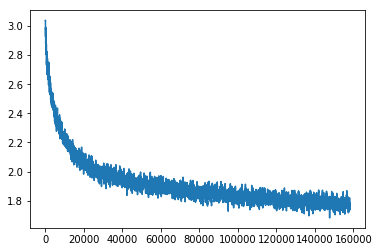

In [32]:
learner.sched.plot_loss()

# Classifier tokens

In [ ]:
# tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')

In [ ]:
# tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [10]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

# Classifier

In [11]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [12]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [13]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 50

In [14]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [15]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [16]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [17]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.7

In [18]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [19]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [20]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [21]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [22]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [23]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [19]:
learn.freeze_to(-1)

In [20]:
learn.lr_find(lrs/1000)

 82%|████████▏ | 6460/7913 [32:47<10:29,  2.31it/s, loss=5.48]  

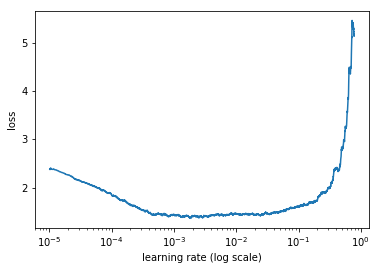

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                       
    0      1.411551   1.184201   0.550166  


[array([1.1842]), 0.5501662010716147]

In [ ]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

In [ ]:
learn.save('clas_1')

In [ ]:
learn.load('clas_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=10, use_clr=(32,10))

 91%|█████████▏| 18502/20256 [2:17:32<09:48,  2.98it/s, loss=1.17]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15%|█▍        | 3001/20256 [21:25<1:20:42,  3.56it/s, loss=1.16]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 37%|███▋      | 7394/20256 [53:09<2:16:17,  1.57it/s, loss=1.12]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 12321/20256 [1:28:28<50:17,  2.63it/s, loss=1.16]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87%|████████▋ | 17560/20256 [2:05:43<13:28,  3.33it/s, loss=1.08]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 10%|▉         | 2013/20256 [14:10<4:23:56,  1.15it/s, loss=1.03] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    2      1.052966   0.647863   0.747438                            
    3      0.952917   0.604134   0.765257                            
    4      0.987211   0.571305   0.775928                            
    5      0.880011   0.555895   0.785488                            
    6      0.864568   0.546907   0.789384                            
 51%|█████▏    | 10383/20256 [1:34:10<2:37:04,  1.05it/s, loss=0.879]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 75%|███████▍  | 15190/20256 [2:25:11<1:07:28,  1.25it/s, loss=0.843]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97%|█████████▋| 19667/20256 [3:12:57<11:35,  1.18s/it, loss=0.855]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 18%|█▊        | 3724/20256 [39:51<1:35:17,  2.89it/s, loss=0.891] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    8      0.860952   0.534182   0.79656                             
  7%|▋         | 1354/20256 [08:51<1:35:31,  3.30it/s, loss=0.772]

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

# Fin

In [24]:
learn.load('clas_2_proce_top10_80-20split_lm_3epochs_classifier_17epochs')

In [25]:
log_preds = learn.predict()

In [26]:
log_preds[0]

array([-11.60222, -12.81531, -12.25366,  -8.09223, -12.4031 ,  -9.99211,  -7.49749,  -4.83515,  -7.08885,
       -12.67337], dtype=float32)

In [27]:
#Reference: https://forums.fast.ai/t/how-to-convert-multi-label-predictions-into-multi-class-probabilities/9450
#convert log_preds between 0 and 1
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

In [28]:
log_preds_sigmoid = sigmoid(log_preds)

/home/snuthakk/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [29]:
log_preds_sigmoid[5]

array([0.     , 0.     , 0.     , 0.0002 , 0.     , 0.00001, 0.00039, 0.00389, 0.00793, 0.     ],
      dtype=float32)

### Predictions

In [30]:
y = log_preds
y

array([[-11.60222, -12.81531, -12.25366, ...,  -4.83515,  -7.08885, -12.67337],
       [-33.94787, -37.62865, -35.90388, ..., -19.74193, -24.87297, -30.55859],
       [-20.64185, -22.41929, -21.55665, ...,  -9.85583, -12.38555, -24.97778],
       ...,
       [  3.40549,   3.03429,   3.3329 , ...,   3.96291,   4.23556,   1.01745],
       [  3.17855,   2.78797,   3.07291, ...,   3.82186,   4.16005,   0.89603],
       [  3.32996,   2.82503,   3.12294, ...,   4.04041,   4.38267,   1.38929]], dtype=float32)

In [31]:
len(y)

126599

In [32]:
y.shape

(126599, 10)

In [33]:
predicted_values = np.argmax(y, axis=1)
predicted_values

array([7, 6, 7, ..., 8, 8, 8])

In [34]:
np.unique(predicted_values)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
len(predicted_values)

126599

In [36]:
predicted_valuesd_values.shape

(126599,)

### Actual values

In [37]:
x,z = next(iter(md.val_dl))

In [38]:
a = []
for x,z in iter(md.val_dl):
    a.append(z)
print(a)

[
 8
 7
 8
 3
 8
 8
 6
 5
 8
 8
 8
 7
 8
 8
 6
 5
 8
 7
 0
 6
 7
 6
 3
 0
 5
 5
 3
 8
 7
 5
 8
 3
 3
 8
 7
 8
 8
 3
 6
 8
 8
 8
 3
 7
 6
 6
 6
 8
 3
 0
[torch.cuda.LongTensor of size 50 (GPU 0)]
, 
 3
 8
 7
 8
 7
 7
 7
 7
 6
 7
 0
 5
 3
 5
 7
 8
 7
 7
 6
 8
 8
 8
 7
 8
 6
 8
 0
 7
 5
 7
 3
 3
 7
 6
 7
 7
 8
 8
 8
 3
 7
 8
 8
 6
 3
 6
 3
 6
 8
 7
[torch.cuda.LongTensor of size 50 (GPU 0)]
, 
 8
 5
 8
 7
 0
 7
 3
 8
 5
 8
 3
 3
 8
 2
 8
 6
 7
 8
 5
 8
 5
 3
 3
 2
 3
 8
 7
 7
 3
 7
 0
 5
 7
 0
 7
 7
 3
 8
 3
 8
 5
 6
 8
 3
 7
 8
 5
 7
 7
 5
[torch.cuda.LongTensor of size 50 (GPU 0)]
, 
 8
 3
 7
 8
 7
 7
 8
 5
 7
 8
 6
 7
 5
 8
 3
 1
 5
 3
 3
 3
 3
 3
 7
 8
 3
 8
 8
 3
 7
 7
 3
 7
 3
 5
 7
 7
 5
 3
 6
 3
 7
 7
 2
 7
 3
 7
 7
 7
 8
 8
[torch.cuda.LongTensor of size 50 (GPU 0)]
, 
 7
 5
 3
 8
 3
 8
 8
 7
 7
 8
 5
 3
 5
 6
 5
 8
 3
 8
 6
 6
 7
 8
 5
 5
 6
 7
 2
 3
 8
 7
 6
 3
 8
 5
 5
 5
 6
 3
 7
 8
 3
 7
 7
 3
 5
 3
 5
 3
 7
 0
[torch.cuda.LongTensor of size 50 (GPU 0)]
, 
 3
 8
 0
 3
 3
 3


In [39]:
len(a)

2532

In [40]:
type(a)

list

In [41]:
actual_values = [item for sublist in a for item in sublist]
len(actual_values)

126599

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

labels = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9]
cm = confusion_matrix(predicted_values, actual_values, labels)
print(cm)

[[ 5559   429   563   216     0   143   145   275   348     0]
 [  444  2058  1185    82     3   118    86   195   171     4]
 [  443   957  2623    56     0    81    60    97   111     2]
 [   81    22    40  6672     9    73   352   614   517    14]
 [    1     1     0    24  3930     0  1515   413   108  1157]
 [  195   180   295   231     0  3704   204   413   340     0]
 [   61    24    32   404  2372    46 28652  4279  3275  1050]
 [  247   124   188   927   199   199  2085 10247  1941   136]
 [  488   164   259   929    47   281  2173  2702 21223    13]
 [    1     0     1    30   915     1   541   177    20  2587]]


In [45]:
!pip install pandas_ml --user

In [47]:
!pip show pandas_ml

Name: pandas-ml
Version: 0.5.0
Summary: pandas, scikit-learn and xgboost integration
Home-page: http://pandas-ml.readthedocs.org/en/stable
Author: sinhrks
Author-email: sinhrks@gmail.com
License: BSD
Location: /home/snuthakk/.local/lib/python3.5/site-packages
Requires: enum34, pandas
Required-by: 


In [48]:
sys.path.append('/home/snuthakk/.local/lib/python3.5/site-packages')

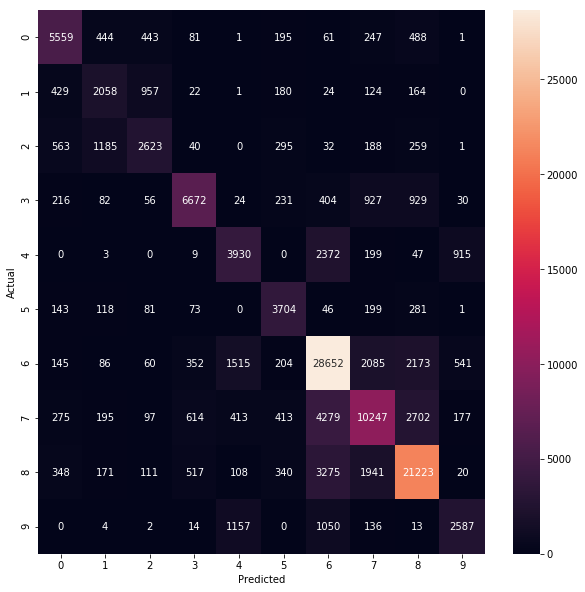

In [49]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

cm = ConfusionMatrix(actual_values, predicted_values)
cm
conf_mat = confusion_matrix(actual_values, predicted_values)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
from sklearn.metrics import classification_report
print(classification_report(actual_values, predicted_values))

             precision    recall  f1-score   support

          0       0.72      0.74      0.73      7520
          1       0.47      0.52      0.50      3959
          2       0.59      0.51      0.55      5186
          3       0.79      0.70      0.74      9571
          4       0.55      0.53      0.54      7475
          5       0.67      0.80      0.73      4646
          6       0.71      0.80      0.75     35813
          7       0.63      0.53      0.57     19412
          8       0.75      0.76      0.75     28054
          9       0.61      0.52      0.56      4963

avg / total       0.69      0.69      0.69    126599



### AUROC testing and output result

In [51]:
actual_values_df = pd.DataFrame(np.array(actual_values), index=None)
print (len(actual_values_df))
print(actual_values_df.head())

126599
   0
0  8
1  7
2  8
3  3
4  8


In [52]:
predicted_values_df = pd.DataFrame(np.array(predicted_values), index = None)
print (len(predicted_values_df))
print(predicted_values_df.head())

126599
   0
0  7
1  6
2  7
3  8
4  3


In [55]:
procedures_top10_actualpredic_values = pd.DataFrame()
procedures_top10_actualpredic_values['actual_values'] = actual_values
procedures_top10_actualpredic_values['predicted_values'] = predicted_values
print(len())
procedures_top10_actualpredic_values.head()

,actual_values,predicted_values
0,8,7
1,7,6
2,8,7
3,3,8
4,8,3


In [56]:
procedures_top10_actualpredic_values.to_csv('procedures_top10_actualpredic_values.csv')

In [82]:
#For multiclass ROC curve dividing data into test and train
#Plotted between 'Manual_Code' and 'SVM_Label'
from sklearn.model_selection import train_test_split
X = actual_values_df[0].values
y = predicted_values_df[0].values

# Add noisy features to make the problem harder
random_state = 0

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2
                                                    ,random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(101279,)
(25320,)
(101279,)
(25320,)


In [83]:
#METHOD 2
#Multiclass ROC curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
X = actual_values_df[0].values
y = predicted_values_df[0].values

# Binarize the output
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = 0

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)
# print(y_test)
# print(len(y_test))
# y_test = predicted_values
# print(len(y_test))
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))

# y_score = log_preds_sigmoid
# print(len(y_score))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# y_score = classifier.fit(X_train.reshape(-1,1), y_train).decision_function(X_test.reshape(-1,1))
y_score = classifier.fit(X_train.reshape(101279,1), y_train).decision_function(X_test.reshape(25320,1))


#Compute ROC curve and ROC area for each class
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

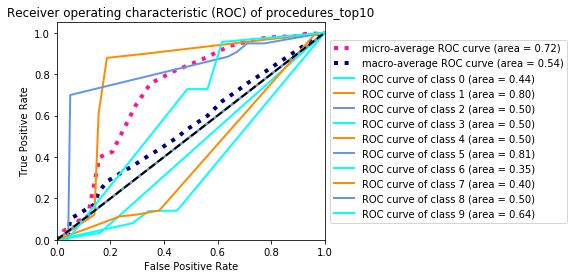

In [84]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic (ROC) of procedures_top10')
ax.legend(loc="best")

#Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [60]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
X = actual_values_df
y = predicted_values_df
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Automatically created module for IPython interactive environment


KeyError: '[  9165   9168   9172 ... 126596 126597 126598] not in index'

Automatically created module for IPython interactive environment
5
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.1 1.5 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [

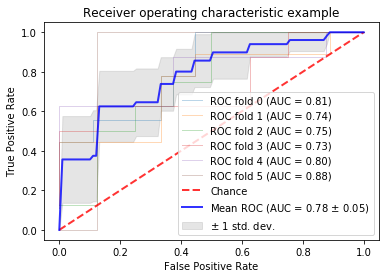

In [64]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
print(len(iris))
X = iris.data
y = iris.target
print(X, y)
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    print(zip(X[test], probas_))
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()